In [1]:
# conditioning 2 wire positions as an extra input channel
# try with attention instead. Look at how clip encoding is done, specifcally how the model receives the data

In [17]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import segmentation_models_pytorch as smp
from diffusers import UNet2DConditionModel, DDPMScheduler

#from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cuda


In [28]:
# Define model and scheduler

imageSize = 32

model = UNet2DConditionModel(
    sample_size=imageSize,   # image resolution
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    cross_attention_dim=imageSize ** 2
    # For unconditional modeling, you don't need extra conditioning.
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = DDPMScheduler(
    num_train_timesteps=100,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="squaredcos_cap_v2",  # cosine-style schedule
)

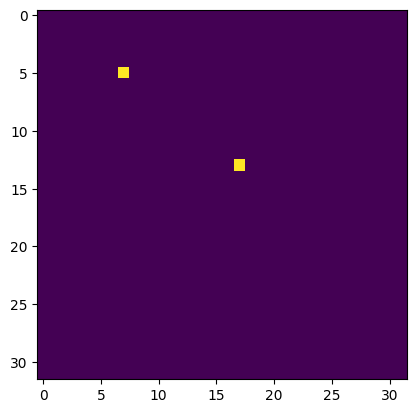

In [5]:
# Attempt to train through inference
# Generate a pair of wire ends and train the network to connect them.
# The wire ends are the conditioning on the model.


# Condition
wireCondition = torch.zeros((1, 1, imageSize, imageSize), device=device)

wireIndexes = torch.randint(imageSize, (2,2))
wireCondition[0, 0, wireIndexes[0,0], wireIndexes[0,1]] = 1
wireCondition[0, 0, wireIndexes[1,0], wireIndexes[1,1]] = 1


plt.imshow(wireCondition.squeeze().cpu().numpy())

In [ ]:
def wireCondToSquare(pos1, pos2):
    image = torch.zeros((1, 1, imageSize, imageSize), device=device)
    image[:, :, 
          min(pos1[0], pos2[0]):max(pos1[0], pos2[0]), 
          min(pos1[1], pos2[1]):max(pos1[1], pos2[1])] = 1.0
    return image

""" # Lets pause doing tree search and just see if we can do square from condition. should be easier. 
# and if it works, perhaps the tree search could be applicable
#pos1, pos2 = condition
#condSquare = wireCondToSquare(pos1, pos2)
#paths = roundedImage + condSquare # paths is 1 where wire may be placed correctly.

def treeSearch(pos1, pos2, paths):
    for i in range(abs(pos1[0] - pos2[0])):
        for j in range(abs(pos1[1] - pos2[1])):
            paths[i, j] = 
"""

def wireLoss(image, condition):
    iouLoss = smp.losses.JaccardLoss(mode='binary')
    roundedImage = torch.where(image < 0.5, 0, 1).float()

    loss = iouLoss(roundedImage, condition)
    return loss

In [44]:
# Training

epochs = 1
model.train()
scheduler.set_timesteps(2)


for epoch in range(epochs):
    optimizer.zero_grad()

    # Conditioning
    # wireCondition = torch.zeros((1, 1, imageSize, imageSize), device=device)
    # wireIndexes = torch.randint(imageSize, (2,2))
    # wireCondition[0, 0, wireIndexes[0,0], wireIndexes[0,1]] = 1
    # wireCondition[0, 0, wireIndexes[1,0], wireIndexes[1,1]] = 1

    #Simpler conditioning (square):
    wireIndexes = torch.randint(imageSize, (2,2))
    pos1, pos2 = wireIndexes
    squareCondition = wireCondToSquare(pos1, pos2).flatten().unsqueeze(0).unsqueeze(0).float().requires_grad_()  

    # Input
    x = torch.randn_like(wireCondition, device=device, requires_grad=True).float()

    for t in scheduler.timesteps:
        print(f"T{t}")
        modelOut = model(x, t, squareCondition).sample

        # The scheduler finds the previous state of the conditioning, but that should be constant.
        stepOut = scheduler.step(modelOut, t, x)
        x = stepOut.prev_sample

    loss = wireLoss(x, squareCondition)
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

plt.imshow(x.squeeze().cpu().numpy())

T50
T0
Epoch [1/1], Loss: 0.8714


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

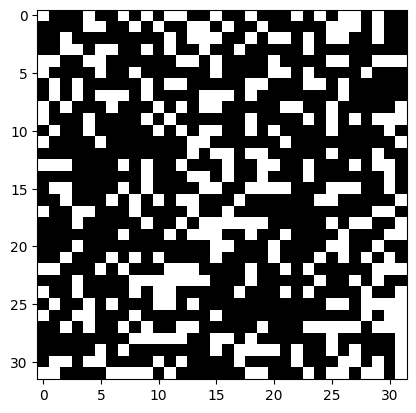

In [32]:
plt.imshow(torch.sign(seed.squeeze()).cpu().numpy(), cmap='binary', vmin=-1, vmax=1)

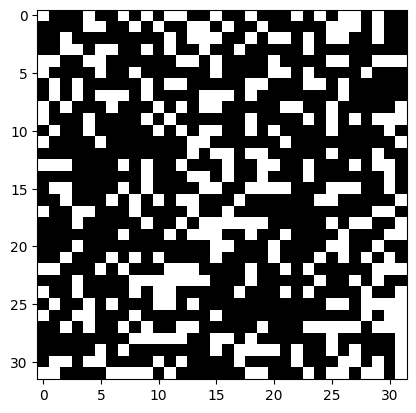

In [ ]:
plt.imshow(wireCondition.squeeze().cpu().numpy())
#plt.imshow(torch.sign(seed.squeeze()).cpu().numpy(), cmap='binary', vmin=-1, vmax=1)
#def wireLoss(image, condition):

# Problem, the loss would require shortest distance path
# and IOU
# Could simulate in minecraft, but that would only give a score and not a gradient

---